# Run Assay Conversion in Notebooks

In [1]:
import os
import re
import torch
import random
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime

# for flex attention
import torch._dynamo
import torch.multiprocessing as mp 
torch._dynamo.config.suppress_errors = True

sc.set_figure_params(figsize=(4, 4))

from cellarium.ml.utilities.inference.cellarium_gpt_inference import \
    CellariumGPTInferenceContext

2025-04-03 14:40:43.738844: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-03 14:40:45.185392: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
ROOT_PATH = "/work/hdd/bbjr/mallina1/data/mb-ml-dev-vm"

ADATA_FP = '/work/hdd/bbjr/mallina1/data/mb-ml-dev-vm/data/pbmc_adata.h5ad'
REF_ADATA_FP = '/work/hdd/bbjr/mallina1/data/mb-ml-dev-vm/data/extract_0.h5ad'
OUT_ADATA_DIR = '/work/hdd/bbjr/mallina1/data/human_cellariumgpt_v2/assay_conversion'

GENE_INFO_PATH = os.path.join(ROOT_PATH, "gene_info", "gene_info.tsv")

# CHECKPOINT_PATH = "/work/hdd/bbjr/mallina1/cellarium/models/compute_optimal_checkpoints/epoch=1-step=28244.ckpt"
CHECKPOINT_PATH = "/work/hdd/bbjr/mallina1/cellarium/models/compute_optimal_checkpoints/epoch=6-step=63560.ckpt"
DEVICE = 'cuda'

# set this according to the KEYS in assay_label_map
TARGET_ASSAY = '10x Chromium (v3)'

# Hard-coding mappings based on the PBMC dataset from Method -> assay and assay_ontology_term_id in CellariumGPT
assay_label_map = {
    "10x Chromium (v2) A": "10x 3' v2",
    "10x Chromium (v2) B": "10x 3' v2",
    "10x Chromium (v3)": "10x 3' v3",
    "Drop-seq": "Drop-seq",
    "Seq-Well": "Seq-Well",
    "inDrops": "inDrop"
}

assay_ontology_term_id_map = {
    "Seq-Well": "EFO:0008919",
    "10x 3' v3": "EFO:0009922",
    "Drop-seq": "EFO:0008722",
    "inDrop": "EFO:0008780",
    "10x 3' v2": "EFO:0009899"
}

In [3]:
ref_adata = sc.read_h5ad(REF_ADATA_FP)
val_adata = sc.read_h5ad(ADATA_FP)

# Obtain Cellarium var_names for subsampling later as well
ref_var_names = set(ref_adata.var_names)

# First subset the validation gene counts to those that show up in Cellarium training
val_adata = val_adata[:, val_adata.var_names.isin(ref_var_names)]

# Next subset by assays that we have relevant data for in Cellarium based on the assay_label_map
val_adata = val_adata[val_adata.obs.Method.isin(list(assay_label_map.keys()))]

# Finally re-order gene columns based on a fixed var_name list just in case
var_names = list(val_adata.var_names)
val_adata = val_adata[:, np.array(var_names)]

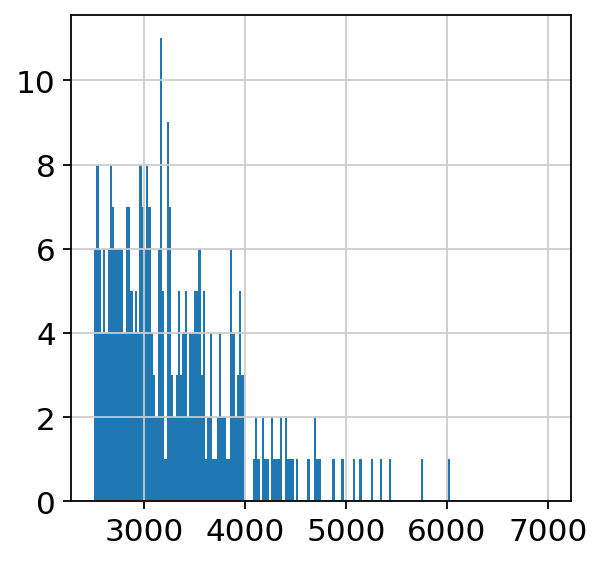

In [ ]:
val_adata.obs.nUMI.astype(int).value_counts().sort_index()

original_methods = ['10x Chromium (v2) A', '10x Chromium (v2) B', '10x Chromium (v3)',
                    'Drop-seq', 'Seq-Well', 'inDrops']

val_assay = val_adata[val_adata.obs.Method == original_methods[5]]

plt.hist(val_assay.obs.nUMI.astype(int).values, bins=200, range=(2500, 7000))
plt.show()

# truncate nUMIs from 500 - 1k
# meta cell in a notebook
# highly-variable, highly-expressed, concat highly-variable across assay + cell type
# query umis at mean / mode
# save logits
# query with max counts = 500
# query with fewer genes

In [4]:
# Optional subsetting by method and cell type
val_adata = val_adata[val_adata.obs.Method == '10x Chromium (v3)']
val_adata = val_adata[val_adata.obs.CellType == 'B cell']

## Load inference context

In [5]:
ctx = CellariumGPTInferenceContext(
    cellarium_gpt_ckpt_path=CHECKPOINT_PATH,
    ref_adata_path=REF_ADATA_FP,
    gene_info_tsv_path=GENE_INFO_PATH,
    device=DEVICE,
    attention_backend="mem_efficient"
)

In [6]:
processed_val_adata = val_adata.copy()

processed_val_adata.obs['assay'] = val_adata.obs['Method'].map(assay_label_map)
processed_val_adata.obs['assay_ontology_term_id'] = processed_val_adata.obs['assay'].map(assay_ontology_term_id_map)
processed_val_adata.obs['suspension_type'] = 'cell'
processed_val_adata.obs['total_mrna_umis'] = processed_val_adata.obs.nUMI.astype(np.int64)

# Get random values for cell_type, tissue, disease, sex, and development_stage from ref_adata
# since we are going to mask all of this anyway, just needed to have a valid category in the
# get_tokens_from_adata function.

processed_val_adata.obs['cell_type_ontology_term_id'] = [ctx.metadata_ontology_infos['cell_type']['names'][0]] * val_adata.shape[0]
processed_val_adata.obs['tissue_ontology_term_id'] = [ctx.metadata_ontology_infos['tissue']['names'][0]] * val_adata.shape[0]
processed_val_adata.obs['disease_ontology_term_id'] = [ctx.metadata_ontology_infos['disease']['names'][0]] * val_adata.shape[0]
processed_val_adata.obs['sex_ontology_term_id'] = [ctx.metadata_ontology_infos['sex']['names'][0]] * val_adata.shape[0]
processed_val_adata.obs['development_stage_ontology_term_id'] = [ctx.metadata_ontology_infos['development_stage']['names'][0]] * val_adata.shape[0]

In [7]:
processed_val_adata.obs

,NAME,nGene,nUMI,percent.mito,Cluster,CellType,Experiment,Method,assay,assay_ontology_term_id,suspension_type,total_mrna_umis,cell_type_ontology_term_id,tissue_ontology_term_id,disease_ontology_term_id,sex_ontology_term_id,development_stage_ontology_term_id
6697,pbmc1_10x_v3_AAACCCACACTTGGGC,1860,6914,0.0911194677466011,1,CD4+ T cell,pbmc1,10x Chromium (v3),10x 3' v3,EFO:0009922,cell,6914,CL:0000540,UBERON:0002228,PATO:0000461,PATO:0000384,HsapDv:0000002
6698,pbmc1_10x_v3_AAACCCATCTTACACT,1758,6168,0.0856031128404669,1,CD4+ T cell,pbmc1,10x Chromium (v3),10x 3' v3,EFO:0009922,cell,6168,CL:0000540,UBERON:0002228,PATO:0000461,PATO:0000384,HsapDv:0000002
6699,pbmc1_10x_v3_AAAGAACAGCAGGCAT,2425,8265,0.0815486993345433,1,CD4+ T cell,pbmc1,10x Chromium (v3),10x 3' v3,EFO:0009922,cell,8265,CL:0000540,UBERON:0002228,PATO:0000461,PATO:0000384,HsapDv:0000002
6700,pbmc1_10x_v3_AAAGAACTCAAAGACA,1553,5789,0.0730696147866644,1,CD4+ T cell,pbmc1,10x Chromium (v3),10x 3' v3,EFO:0009922,cell,5789,CL:0000540,UBERON:0002228,PATO:0000461,PATO:0000384,HsapDv:0000002
6701,pbmc1_10x_v3_AAAGTCCGTAGGCAGT,2655,9163,0.0966932227436429,1,CD4+ T cell,pbmc1,10x Chromium (v3),10x 3' v3,EFO:0009922,cell,9163,CL:0000540,UBERON:0002228,PATO:0000461,PATO:0000384,HsapDv:0000002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9885,pbmc1_10x_v3_TTCATGTAGAGGTGCT,1065,3376,0.0832345971563981,1,CD4+ T cell,pbmc1,10x Chromium (v3),10x 3' v3,EFO:0009922,cell,3376,CL:0000540,UBERON:0002228,PATO:0000461,PATO:0000384,HsapDv:0000002
9887,pbmc1_10x_v3_TTCGCTGCAACTGGTT,1489,4289,0.15178363254838,1,CD4+ T cell,pbmc1,10x Chromium (v3),10x 3' v3,EFO:0009922,cell,4289,CL:0000540,UBERON:0002228,PATO:0000461,PATO:0000384,HsapDv:0000002
9888,pbmc1_10x_v3_TTGGGATTCATGAGAA,1377,4521,0.100420261004203,1,CD4+ T cell,pbmc1,10x Chromium (v3),10x 3' v3,EFO:0009922,cell,4521,CL:0000540,UBERON:0002228,PATO:0000461,PATO:0000384,HsapDv:0000002
9889,pbmc1_10x_v3_TTTCACAAGGTACTGG,1570,5749,0.12645677509132,1,CD4+ T cell,pbmc1,10x Chromium (v3),10x 3' v3,EFO:0009922,cell,5749,CL:0000540,UBERON:0002228,PATO:0000461,PATO:0000384,HsapDv:0000002


In [ ]:
metadata_prompt_dict = {
    "cell_type": False,
    "tissue": False,
    "disease": False,
    "sex": False,
    "development_stage": False
}

# target_assay = '10x Chromium (v3)
target_assay = TARGET_ASSAY
n_fixed_query_genes = 4096

sample_indices = random.sample(range(len(var_names)), n_fixed_query_genes)
sample_indices.sort()
fixed_query_genes = [var_names[i] for i in sample_indices]  

adata_fixed_genes_original = processed_val_adata[:, np.array(fixed_query_genes)].copy()
adata_fixed_genes_converted = adata_fixed_genes_original.copy()
adata_fixed_genes_means = adata_fixed_genes_original.copy()

batch_size = 32
X_lil = adata_fixed_genes_converted.X.tolil()
X_lil_means = adata_fixed_genes_means.X.tolil()

batch_obs_idx = []
batch_query_total_mrna_umis = []
skipped_row = []
pbar = tqdm(total=adata_fixed_genes_original.shape[0])
for val_obs_idx in range(0, adata_fixed_genes_original.shape[0]):
    pbmc_cell_type = adata_fixed_genes_original.obs.iloc[val_obs_idx].CellType

    # UMIs by cell type and target assay in order to sample from in conversion
    pbmc_umis = val_adata[val_adata.obs.CellType == pbmc_cell_type]
    pbmc_umis = pbmc_umis[pbmc_umis.obs.Method == target_assay]

    # Use the global nUMI in the adata to sample from
    pbmc_umis = pbmc_umis.obs.nUMI.to_numpy()

    if len(pbmc_umis) == 0:
        skipped_row.append(True)
        pbar.update(1)
        continue

    query_total_mrna_umis = np.random.choice(pbmc_umis, size=(n_fixed_query_genes,), replace=True)
    query_total_mrna_umis = np.array(query_total_mrna_umis, dtype=np.int64)
    batch_query_total_mrna_umis.append(query_total_mrna_umis[None, :])
    batch_obs_idx.append(val_obs_idx)
    skipped_row.append(False)

    if len(batch_obs_idx) < batch_size and val_obs_idx != adata_fixed_genes_original.shape[0] - 1:
        continue

    batch_query_total_mrna_umis = np.concatenate(batch_query_total_mrna_umis, axis=0)
    query_assay = assay_label_map[target_assay]
    query_assay_ontology_term_id = assay_ontology_term_id_map[query_assay]

    with torch.no_grad():
        tokens_dict, context_indices = ctx.generate_tokens_from_adata(adata_fixed_genes_original, 
                                                                      obs_index=batch_obs_idx, 
                                                                      query_var_names=fixed_query_genes,
                                                                      metadata_prompt_masks_dict=metadata_prompt_dict,
                                                                      query_total_mrna_umis=batch_query_total_mrna_umis,
                                                                      query_assay_ontology_term_id=query_assay_ontology_term_id)
        

        gene_logits_nqk = ctx.get_gene_value_logits_from_tokens(tokens_dict,
                                                                context_indices,
                                                                max_counts=None)
        
        gene_marginal_mean_nq, _ = ctx.calculate_gene_mean_std_from_logits(gene_logits_nqk,
                                                                           gene_logits_nqk.shape[-1],
                                                                           use_logsumexp=True)


        for idx_in_batch, idx_in_adata in enumerate(batch_obs_idx):
            dist = torch.distributions.categorical.Categorical(logits = gene_logits_nqk[idx_in_batch].squeeze())
            row_sample = dist.sample().cpu().numpy()
            X_lil[idx_in_adata,:] = row_sample 
            X_lil_means[idx_in_adata,:] = gene_marginal_mean_nq[idx_in_batch].cpu().numpy().squeeze()

    pbar.update(len(batch_obs_idx))
    batch_obs_idx = []
    batch_query_total_mrna_umis = []

adata_fixed_genes_converted.X = X_lil.tocsr()
adata_fixed_genes_means.X = X_lil_means.tocsr()

skipped_row = np.array(skipped_row).astype(bool)

adata_fixed_genes_original = adata_fixed_genes_original[~skipped_row]
adata_fixed_genes_converted = adata_fixed_genes_converted[~skipped_row]
adata_fixed_genes_means = adata_fixed_genes_means[~skipped_row]

  0%|                                                                                                                   | 0/960 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 960/960 [05:56<00:00,  2.70it/s]

In [ ]:
formatted = datetime.now().strftime("%Y_%m_%d_%H_%M")

filename = f'{formatted}_convert_to_{"_".join(target_assay.split())}'
clean_filename = re.sub(r'[^a-zA-Z0-9._-]', '', filename)

target_assay_out_dir = os.path.join(OUT_ADATA_DIR, clean_filename)
os.makedirs(target_assay_out_dir)

results_fp1 = os.path.join(target_assay_out_dir, f'original.h5ad')
results_fp2 = os.path.join(target_assay_out_dir, f'converted.h5ad')
results_fp3 = os.path.join(target_assay_out_dir, f'converted_means.h5ad')

for adata in [adata_fixed_genes_original, adata_fixed_genes_converted, adata_fixed_genes_means]:
    del adata.obs['cell_type_ontology_term_id']
    del adata.obs['tissue_ontology_term_id']
    del adata.obs['disease_ontology_term_id']
    del adata.obs['sex_ontology_term_id']
    del adata.obs['development_stage_ontology_term_id']

sc.write(results_fp1, adata_fixed_genes_original)
sc.write(results_fp2, adata_fixed_genes_converted)
sc.write(results_fp3, adata_fixed_genes_means)